In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16,8)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/My Drive"
%cd "cais_projectx"
%ls

/content/drive/My Drive
/content/drive/.shortcut-targets-by-id/1Wikgi8q0u-ej4GsYdTGtowYjbh0dhQ69/cais_projectx
 b1610/                  GB_cycling_Data.csv        'Terminology & Notes.gdoc'
'Deliverable 2 '/        generator_clean.csv         timeseries_lstm.ipynb
 download_b1610.ipynb    labels_and_features.ipynb   Untitled0.ipynb
 download_elexon.ipynb   preprocessed_data.csv
 fuelhh/                 startups.csv


# Preprocessed Elexon

In [ ]:
# !wget "https://zenodo.org/record/3474820/files/GB_cycling_data.csv?download=1"

In [4]:
import pandas as pd
df = pd.read_csv("GB_cycling_Data.csv")
df.head()

,date,metered_wind_MWh,unmetered_wind_MWh,solar_MWh,total_IRES_generation_MWh,total_generation_MWh,IRES_penetration,annual_active_baseload_gens,startups_baseload,load_factor_baseload,severe_ramping_events
0,2009-01-01,1424.186,1576.0,0.0,3000.186,964458.712,0.003111,103,10,0.763896,56
1,2009-01-02,1322.626,7017.5,0.0,8340.126,1003192.101,0.008314,103,25,0.804520,60
2,2009-01-03,2064.088,4449.0,0.0,6513.088,989778.277,0.006580,103,25,0.796835,71
3,2009-01-04,2249.375,7928.5,0.0,10177.875,1000343.980,0.010174,103,26,0.810829,78
4,2009-01-05,2319.008,12214.0,0.0,14533.008,1151107.626,0.012625,103,30,0.843870,66


# Fuel Type Elexon

In [5]:
df = pd.read_csv("fuelhh/fuelhh_2020.csv")
df.head()

,#Settlement Date,Settlement Period,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTNEM
0,2020-01-01,1,7912,0,670,6953,5004,0,672,3,130,1704,0,854,0,2353,854
1,2020-01-01,2,8420,0,670,6949,5043,0,669,3,123,1704,0,852,0,2358,854
2,2020-01-01,3,8037,0,670,6952,5030,0,662,3,122,1704,0,852,0,2356,854
3,2020-01-01,4,7499,0,670,6948,4825,0,591,3,122,1704,0,852,0,2343,854
4,2020-01-01,5,7020,0,669,6954,4689,0,548,3,121,1704,0,852,0,2356,854


In [6]:
plt.scatter(df['IRES_penetration'].iloc[::7], df['load_factor_baseload'].iloc[::7], alpha=0.5)

KeyError: ignored

In [ ]:
n = len(df) // 7

m = len(df) % 7
ires_avgs = np.ndarray(n + 1 if m else n)
lf_avgs = np.ndarray(n + 1 if m else n)

for i in range(n):
  ires_avgs[i] = np.mean(df['IRES_penetration'][i*7:(i+1)*7].to_numpy())
  lf_avgs[i] = np.mean(df['load_factor_baseload'][i*7:(i+1)*7].to_numpy())

if m:
  ires_avgs[-1] = np.mean(df['IRES_penetration'][-m:].to_numpy())
  lf_avgs[-1] = np.mean(df['load_factor_baseload'][-m:].to_numpy())

[[ 1.         -0.65759489]
 [-0.65759489  1.        ]]


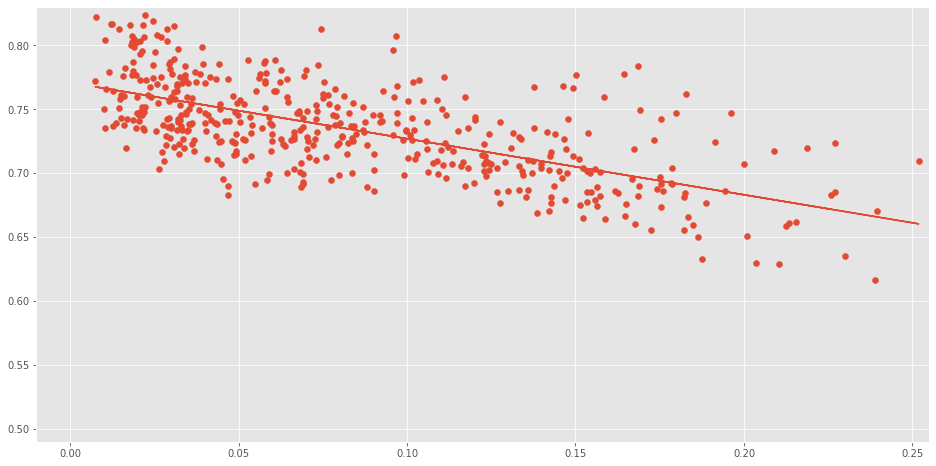

In [ ]:
plt.xlim((-0.01, 0.255))
plt.ylim((0.49, 0.83))
m, b = np.polyfit(ires_avgs, lf_avgs, 1)
plt.plot(ires_avgs, m*ires_avgs + b)
print(np.corrcoef(ires_avgs, lf_avgs))
plt.scatter(ires_avgs, lf_avgs)

#TODO: calculate MAPE


Testing neural net

In [ ]:
import tensorflow as tf
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
df2 = df.drop(columns=['severe_ramping_events', 'startups_baseload', 'annual_active_baseload_gens', 'date'])
df2.head()



,metered_wind_MWh,unmetered_wind_MWh,solar_MWh,total_IRES_generation_MWh,total_generation_MWh,IRES_penetration,load_factor_baseload
0,1424.186,1576.0,0.0,3000.186,964458.712,0.003111,0.763896
1,1322.626,7017.5,0.0,8340.126,1003192.101,0.008314,0.804520
2,2064.088,4449.0,0.0,6513.088,989778.277,0.006580,0.796835
3,2249.375,7928.5,0.0,10177.875,1000343.980,0.010174,0.810829
4,2319.008,12214.0,0.0,14533.008,1151107.626,0.012625,0.843870


In [ ]:
targets = df2.pop('load_factor_baseload')

In [ ]:
df2.describe().transpose()[['mean', 'std']]



,mean,std
metered_wind_MWh,39502.783346,35676.443133
unmetered_wind_MWh,20191.316554,12690.995744
solar_MWh,11545.504896,14972.660986
total_IRES_generation_MWh,71239.604797,52660.017267
total_generation_MWh,873189.616125,106006.341998
IRES_penetration,0.083491,0.064009


In [ ]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(df2))
print(normalizer.mean.numpy())

[3.9502785e+04 2.0191316e+04 1.1545505e+04 7.1239602e+04 8.7318962e+05
 8.3490871e-02]


In [ ]:
first = np.array(df2[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [[  1424.19   1576.        0.     3000.19 964458.71      0.  ]]

Normalized: [[-1.07 -1.47 -0.77 -1.3   0.86 -1.26]]


In [ ]:
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss='mean_absolute_error',)
  return model

In [ ]:


model = get_compiled_model()
model.fit(df2, targets, epochs=100, validation_split=0.2)


Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

82/82 [==============================] - 0s 3ms/step - loss: 3077.3425 - val_loss: 3432.8020
Epoch 2/100
82/82 [==============================] - 0s 1ms/step - loss: 1313.6437 - val_loss: 1390.1254
Epoch 3/100
82/82 [==============================] - 0s 2ms/step - loss: 1357.7679 - val_loss: 1195.4534
Epoch 4/100
82/82 [==============================] - 0s 1ms/step - loss: 2164.3113 - val_loss: 1000.0753
Epoch 5/100
82/82 [==============================] - 0s 1ms/step - loss: 1268.8063 - val

In [ ]:
for feat, targ in dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))


Features: [1.42418600e+03 1.57600000e+03 0.00000000e+00 3.00018600e+03
 9.64458712e+05 3.11074592e-03], Target: 0.7638963168917912
Features: [1.32262600e+03 7.01750000e+03 0.00000000e+00 8.34012600e+03
 1.00319210e+06 8.31358819e-03], Target: 0.8045202127344927
Features: [2.06408800e+03 4.44900000e+03 0.00000000e+00 6.51308800e+03
 9.89778277e+05 6.58035052e-03], Target: 0.7968353872088592
Features: [2.24937500e+03 7.92850000e+03 0.00000000e+00 1.01778750e+04
 1.00034398e+06 1.01743752e-02], Target: 0.810828888462182
Features: [2.31900800e+03 1.22140000e+04 0.00000000e+00 1.45330080e+04
 1.15110763e+06 1.26252382e-02], Target: 0.8438697033811638
